## Violin Plots Based on Condition

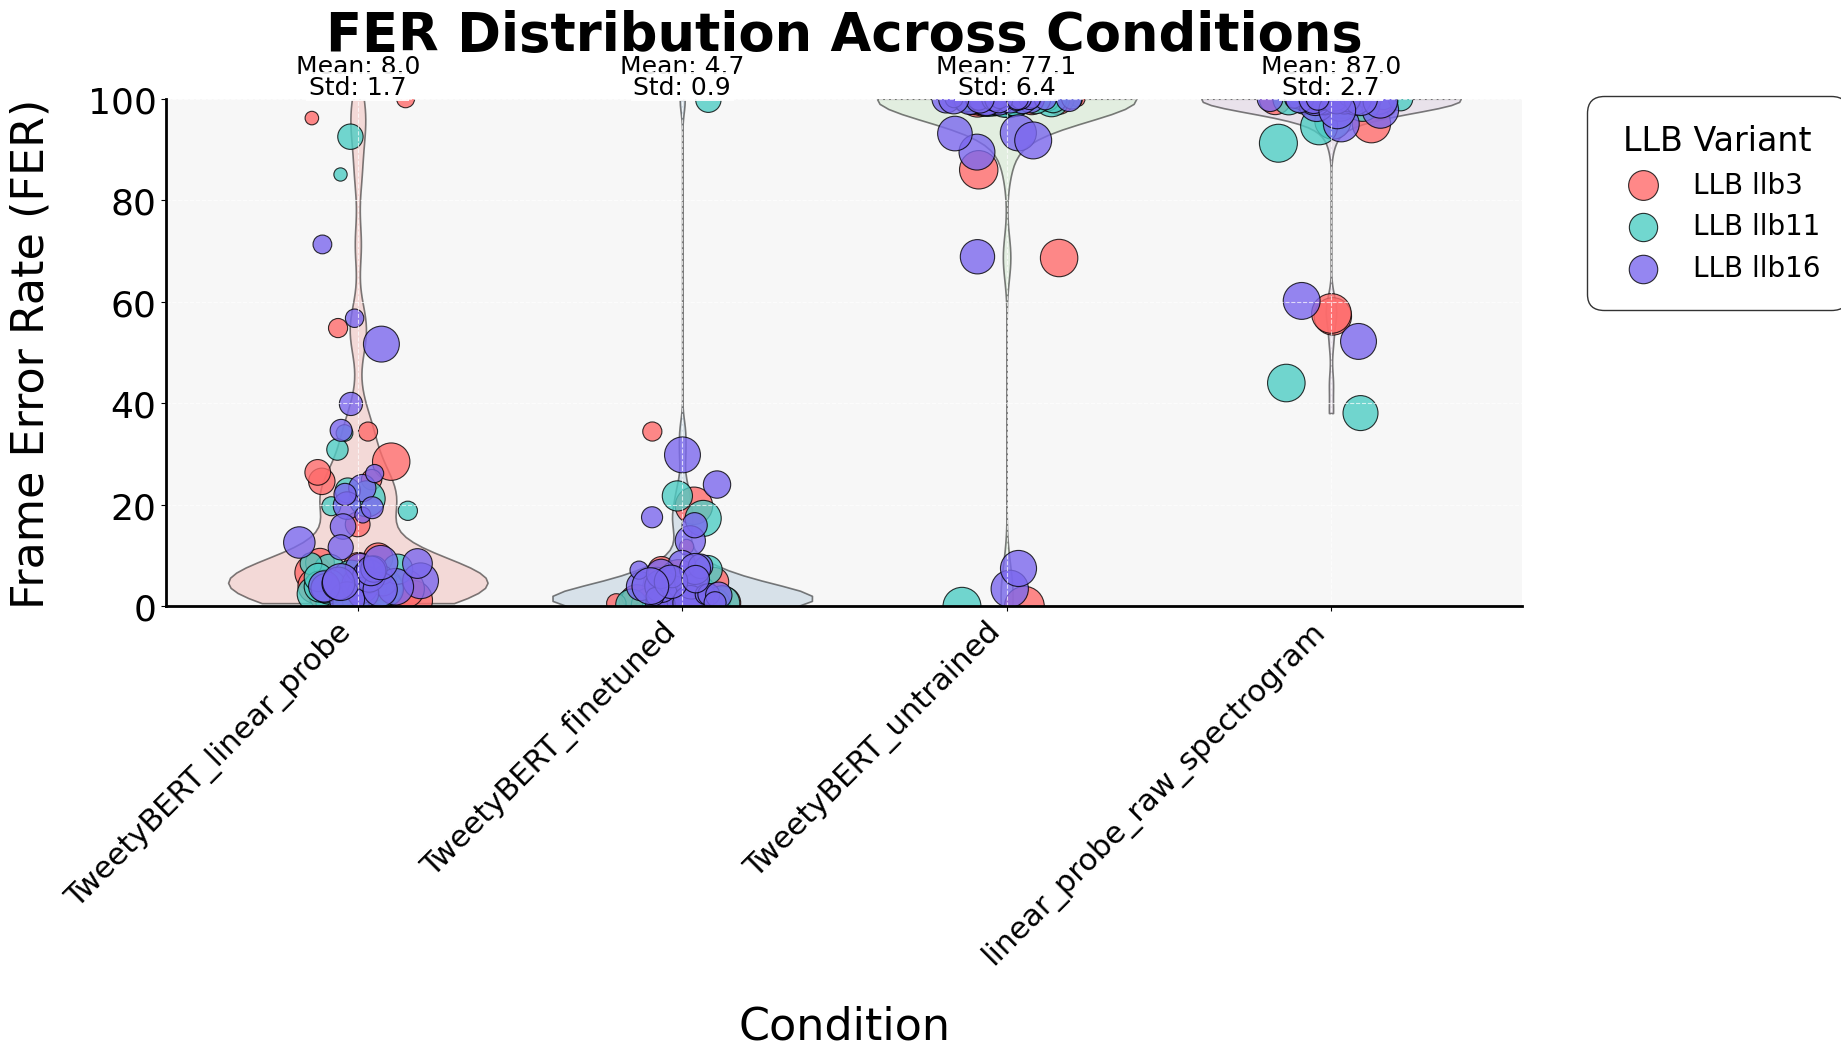

In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Update the base conditions - remove the LLB suffix as we'll combine them
base_conditions = [
    'TweetyBERT_linear_probe',
    'TweetyBERT_finetuned', 
    'TweetyBERT_untrained',
    'linear_probe_raw_spectrogram'
]

# Initialize data structure to store FERs and class proportions
all_data = []
condition_total_fers = defaultdict(list)  # For computing std across LLB variants

# Load JSON files and aggregate data
for llb in ['llb3', 'llb11', 'llb16']:
    for base_cond in base_conditions:
        cond = f"{base_cond}_{llb}"
        cond_path = os.path.join(base_path, cond)
        if not os.path.exists(cond_path):
            print(f"Warning: Directory not found: {cond_path}")
            continue
            
        for filename in os.listdir(cond_path):
            if filename.endswith('.json'):
                filepath = os.path.join(cond_path, filename)
                with open(filepath, 'r') as file:
                    data = json.load(file)
                    
                    # Store total FER for std calculation
                    total_fer = data['total_frame_error_rate']
                    condition_total_fers[base_cond].append(total_fer)
                    
                    # Store individual class FERs and their proportions
                    for class_label, fer in data['class_frame_error_rates'].items():
                        all_data.append({
                            'Condition': base_cond,
                            'LLB': llb,
                            'Class': class_label,
                            'FER': fer,
                            'Proportion': data['class_proportions'][class_label]
                        })

# Set style and color parameters
plt.style.use('default')
plt.figure(figsize=(22, 14))
plt.rcParams.update({
    'font.size': 26,
    'font.family': 'sans-serif',  # Changed from 'Arial' to 'sans-serif' for compatibility
    'axes.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.facecolor': '#f7f7f7',  # Lighter gray background for less distraction
    'figure.facecolor': 'white',
    'grid.color': 'white',
    'grid.linestyle': '-',
    'axes.spines.top': False,     # Remove top spine
    'axes.spines.right': False    # Remove right spine
})

# Define a more distinct color scheme
llb_colors = {
    'llb3': '#FF6B6B',    # Coral red
    'llb11': '#4ECDC4',   # Turquoise
    'llb16': '#7B68EE'    # Medium slate blue
}

# Convert to DataFrame for easier handling
df = pd.DataFrame(all_data)

# Create violin plot with improved visibility
sns.violinplot(x='Condition', y='FER', data=df,
               bw_method=0.2, cut=0, inner=None,  # Updated bw parameter to bw_method
               hue='Condition', palette='Pastel1',
               alpha=0.5, linewidth=1.2, edgecolor='black')

# Set y-axis limit and customize grid
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)

# Add scatter plots with improved styling
for i, cond in enumerate(base_conditions):
    condition_data = df[df['Condition'] == cond]
    
    for llb, color in llb_colors.items():
        llb_data = condition_data[condition_data['LLB'] == llb]
        # Scale point sizes logarithmically with a minimum size
        sizes = [max(80, np.log(prop * 1000 + 1) * 150) for prop in llb_data['Proportion']]
        
        plt.scatter(np.random.normal(i, 0.08, size=len(llb_data)), 
                   llb_data['FER'],
                   color=color, 
                   edgecolor='black',
                   linewidth=0.8,
                   alpha=0.8,  # Increased transparency for improved clarity
                   s=sizes,
                   label=f'LLB {llb}' if i == 0 else "")
    
    # Update statistics display using total FERs
    mean = np.mean(condition_total_fers[cond])
    std_dev = np.std(condition_total_fers[cond])
    plt.text(i, 104, f'Mean: {mean:.1f}',
             ha='center', va='bottom', 
             fontsize=18,
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))
    plt.text(i, 100, f'Std: {std_dev:.1f}',
             ha='center', va='bottom', 
             fontsize=18,
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=2))

# Customize plot appearance
plt.title('FER Distribution Across Conditions', 
         fontsize=38, pad=35, fontweight='bold')
plt.xlabel('Condition', fontsize=32, labelpad=25)
plt.ylabel('Frame Error Rate (FER)', fontsize=32, labelpad=25)

# Improve x-axis labels
plt.xticks(rotation=45, ha='right')
for label in plt.gca().get_xticklabels():
    label.set_fontsize(22)

# Add legend with updated styling
legend = plt.legend(title='LLB Variant', 
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left', 
                   fontsize=20,
                   title_fontsize=24,
                   frameon=True,
                   edgecolor='black',
                   facecolor='white')
legend.get_frame().set_boxstyle('round', pad=0.6)

# Adjust layout for better spacing
plt.tight_layout(pad=5)
plt.show()


## Layer Wise FER

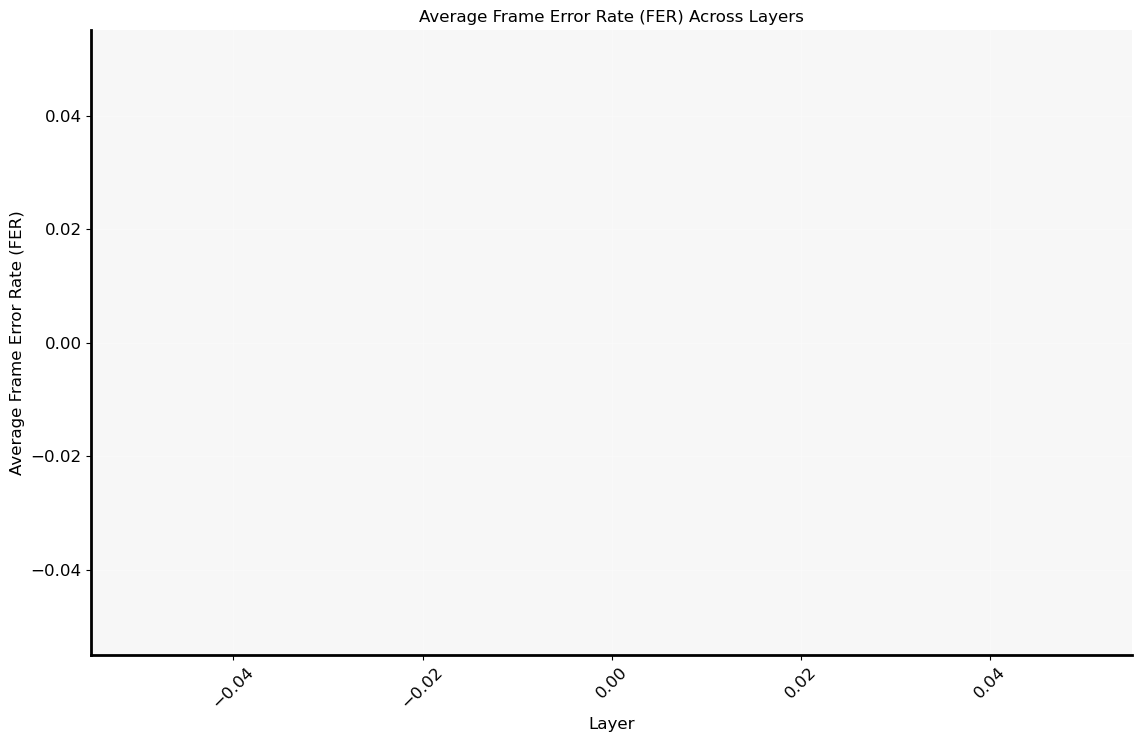

In [21]:

## Layer Wise FER

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing folders with JSON files
base_dir = 'results/layer_wise_analysis/LLB_Model_For_Paper'

# Initialize lists to store data for plotting
layers = []
average_fer = []
std_fer = []

# Modified function to extract layer number from directory name
def get_layer_number(dirname):
    # Extract number from format "layer_X_Q" or "layer_X_K"
    try:
        return int(dirname.split('_')[1])
    except (IndexError, ValueError):
        return float('inf')  # Return infinity for non-layer directories

# Process each LLB variant
for llb_dir in ['llb3', 'llb11', 'llb16']:
    llb_path = os.path.join(base_dir, llb_dir)
    if not os.path.exists(llb_path):
        continue
        
    # Get all layer directories (excluding combined_layer_results.json)
    layer_dirs = [d for d in os.listdir(llb_path) 
                 if os.path.isdir(os.path.join(llb_path, d)) 
                 and d.startswith('layer_')]
    
    # Sort layer directories by layer number
    layer_dirs.sort(key=get_layer_number)
    
    for layer_dir in layer_dirs:
        layer_total_fer = []
        layer_class_fers = []
        
        # Process results for this layer
        results_file = os.path.join(llb_path, layer_dir, 'results.json')
        if os.path.exists(results_file):
            with open(results_file, 'r') as file:
                data = json.load(file)
                
                # Extract FER data
                layer_total_fer.append(data['total_frame_error_rate'])
                class_fers = list(data['class_frame_error_rates'].values())
                layer_class_fers.extend(class_fers)
        
        if layer_total_fer:  # Only process if we have data
            avg_fer = np.mean(layer_total_fer)
            std_dev_fer = np.std(layer_class_fers)
            
            layers.append(layer_dir)
            average_fer.append(avg_fer)
            std_fer.append(std_dev_fer)

# Convert to DataFrame for easier handling
df = pd.DataFrame({
    'Layer': layers,
    'Average FER': average_fer,
    'Std Dev FER': std_fer
})

# Sort DataFrame by the layer number
df['Layer_num'] = df['Layer'].apply(lambda x: int(x.split('_')[1]))
df = df.sort_values('Layer_num')

# Plotting the line plot with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(df['Layer'], df['Average FER'], yerr=df['Std Dev FER'], fmt='-o', capsize=5, capthick=2)

plt.title('Average Frame Error Rate (FER) Across Layers', fontsize=12)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Frame Error Rate (FER)', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

## Output Structure: 
# results/
# └── layer_wise_analysis/
#     ├── llb3/
#     │   ├── layer_0_Q/
#     │   ├── layer_1_K/
#     │   └── combined_layer_results.json
#     ├── llb11/
#     │   ├── layer_0_Q/
#     │   ├── layer_1_K/
#     │   └── combined_layer_results.json
#     └── llb16/
#         ├── layer_0_Q/
#         ├── layer_1_K/
#         └── combined_layer_results.json